<a href="https://colab.research.google.com/github/Abhishek-TyRnT/TyRnT/blob/master/Semanticsegmentation_using_FRRNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install --upgrade tensorflow

     |████████████████████████████████| 421.8MB 13kB/s 
     |████████████████████████████████| 3.8MB 39kB/s 
     |████████████████████████████████| 450kB 45.0MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link="https://drive.google.com/open?id=1J2u3pi-GYXuqa4v30kw0-VQVgi7jMALi"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('cityscapes-image-pairs.zip')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile
with ZipFile("cityscapes-image-pairs.zip",'r') as zipf:
  zipf.extractall()

In [0]:
def encode(image):
  palette=np.array([
         [0,0,0],                           #black
         [128,63,128],                      #Road
         [244,35,232],                      #Sidewalk
         [70,70,70],                        #Building
         [102,102,156],                     #Wall
         [190,153,153],                     #Fence
         [153,153,153],                     #Pole
         [250,170,30],                      #Traffic Light
         [220,220,0],                       #Traffic Sign
         [107,142,35],                      #Vegetation
         [152,251,152],                     #Terrain
         [70,130,180],                      #Sky
         [220,20,60],                       #Person
         [255,0,0],                         #Rider
         [0,0,142],                         #Car
         [0,0,70],                          #Truck
         [0,60,100],                        #Bus
         [0,80,100],                        #Train
         [0,0,230],                         #Motorcycle
         [119,11,32]                        #Bicycle
  ])

  norms=np.empty(shape=(256,256,20))
  for i in range(20):
    obj=np.empty(shape=(256,256,3),dtype=np.int32)
    obj[:,:,0],obj[:,:,1],obj[:,:,2]=palette[i][0],palette[i][1],palette[i][2]
    norms[:,:,i]=np.sqrt(np.sum(np.square(image-obj),axis=-1))
  #plt.imshow(obj)
  #plt.title(str(i))
  #plt.show()
  index=np.argmin(norms,axis=-1)
  I=np.eye(20)
  return I[index]

In [0]:
def decode(pred_mask):
    palette=np.array([
         [0,0,0],                           #black
         [128,63,128],                      #Road
         [244,35,232],                      #Sidewalk
         [70,70,70],                        #Building
         [102,102,156],                     #Wall
         [190,153,153],                     #Fence
         [153,153,153],                     #Pole
         [250,170,30],                      #Traffic Light
         [220,220,0],                       #Traffic Sign
         [107,142,35],                      #Vegetation
         [152,251,152],                     #Terrain
         [70,130,180],                      #Sky
         [220,20,60],                       #Person
         [255,0,0],                         #Rider
         [0,0,142],                         #Car
         [0,0,70],                          #Truck
         [0,60,100],                        #Bus
         [0,80,100],                        #Train
         [0,0,230],                         #Motorcycle
         [119,11,32]                        #Bicycle
  ])
    
    pred_mask=tf.argmax(pred_mask,axis=-1)

    return palette[pred_mask.numpy()]

In [0]:
def gamma_augmentation(image):
  gamma=tf.random.uniform(shape=[1],minval=-0.3,maxval=0.3)
  gamma = tf.math.log( 0.5 + 1 / np.sqrt(2) * gamma) / tf.math.log(0.5 - 1 / np.sqrt(2) * gamma)
  gamma=tf.cast(gamma,tf.double)
  image=tf.keras.backend.pow(image,gamma)
  return image

def translation_augmentation(image,target):
  shift = tf.random.uniform(shape=[2], minval=-50, maxval=50, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  roll_image_1 = tf.roll(tf.roll(image, shift_right, axis=1), shift_down, axis=0)
  roll_image_2 = tf.roll(tf.roll(target, shift_right, axis=1), shift_down, axis=0)
  image=tf.reshape(roll_image_1,shape=(256,256,3))
  target=tf.reshape(roll_image_2,shape=(256,256,20))
  return image,target

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
def load(image):
  w=image.shape[1]
  w = w // 2
  real_image = image[:, :w,:]
  output_image = image[:, w:,:]
  output_image = tf.cast(output_image, tf.int32)
  real_image = tf.cast(real_image, tf.int32)
  real_image=tf.reshape(real_image,shape=(256,256,3))
  output_image=encode(output_image)
  output_image=tf.reshape(output_image,shape=(256,256,20))
  return real_image/255, output_image


In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
def image_generator_val(start):
  data_dir="cityscapes_data" 
  category="val"
  path=os.path.join(data_dir,category)
  for img in os.listdir(path):
     image=tf.io.read_file(os.path.join(path,img))
     image=tf.image.decode_jpeg(image)
     x,y=load(image)
     yield x,y
     
def image_generator_train(start):
  gamma_list=np.random.randint(0,2975,size=[297])
  translation_list=np.random.randint(0,2975,size=[298])
  data_dir="cityscapes_data" 
  category="train"
  i=0
  path=os.path.join(data_dir,category)
  for img in os.listdir(path):
     image=tf.io.read_file(os.path.join(path,img))
     image=tf.image.decode_jpeg(image)
     x,y=load(image)
     yield x,y
     if i in translation_list:
       x,y=translation_augmentation(x,y)
       yield x,y
     if i in gamma_list:
       x=gamma_augmentation(x)
       yield x,y
     
     i=i+1

     



In [0]:
dataset_train=tf.data.Dataset.from_generator(image_generator_train,args=[3570],output_types=(tf.float32,tf.float32),output_shapes=(tf.TensorShape([256,256,3]),tf.TensorShape([256,256,20])))
dataset_val=tf.data.Dataset.from_generator(image_generator_val,args=[500],output_types=(tf.float32,tf.float32),output_shapes=(tf.TensorShape([256,256,3]),tf.TensorShape([256,256,20])))

In [0]:

dataset_train=dataset_train.shuffle(100).repeat().batch(3)
dataset_val=dataset_train.shuffle(100)

In [0]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch,y in ds]
  print(len(batch_sizes))
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')
  return batch_sizes


Data augmentation

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

class FRRU(layers.Layer):
  def __init__(self,pooling,base_channels=32,lanes=32,multiplier=None,name=None):
    super(FRRU, self).__init__(name=name)
    self.base_channels=base_channels
    self.lanes=lanes
    self.pooling=pooling
    self.multiplier=multiplier
    self.names=name

    if self.multiplier is None:
      self.multiplier=pooling
    self.channels=int(self.base_channels*self.multiplier)
    if self.pooling>1:
      self.max_pool=tf.keras.layers.MaxPool2D(strides=pooling,pool_size=[pooling,pooling])
    self.conv_1,self.BN_1=self.add_conv(num_filters=self.channels)
    self.conv_2,self.BN_2=self.add_conv(num_filters=self.channels)

    self.res_conv=self.add_conv(num_filters=self.lanes,filter_size=(1,1),batch_norm=False,bias=True)

    if self.pooling>1:
      self.upsample=tf.keras.layers.UpSampling2D(size=(pooling,pooling))
  def add_conv(self,num_filters=64,filter_size=(3,3),batch_norm=True,bias=False,name=None):
    conv=tf.keras.layers.Conv2D(activation="relu",kernel_size=filter_size,use_bias=bias,filters=num_filters,padding='SAME',kernel_initializer=tf.keras.initializers.he_uniform(),name=name)
    if batch_norm:
      BN=tf.keras.layers.BatchNormalization()
      return conv,BN
    return conv
  def call(self,pooling_stream,residual_stream):
    residual_input=residual_stream
    if self.pooling>1:
      residual_input=self.max_pool(residual_input)

    pooling_stream=tf.keras.layers.concatenate([pooling_stream,residual_input])
    pooling_stream=self.conv_1(pooling_stream)
    pooling_stream=self.BN_1(pooling_stream)

    pooling_stream=self.conv_2(pooling_stream)
    pooling_stream=self.BN_2(pooling_stream)

    residual=self.res_conv(pooling_stream)

    if self.pooling>1:
      residual=self.upsample(residual)

    residual_stream=residual_stream+residual
    return pooling_stream,residual_stream


In [0]:
class RU(layers.Layer):
  def __init__(self,channels_in,channels_out):
    super(RU,self).__init__(name='')
    self.channels_in=channels_in
    self.channels_out=channels_out
    if self.channels_in!=self.channels_out:
      self.conv_1=tf.keras.layers.Conv2D(activation="relu",filters=self.channels_out,kernel_size=(1,1),use_bias=False,kernel_initializer=tf.keras.initializers.he_uniform(),padding='SAME')
    self.conv_2=tf.keras.layers.Conv2D(activation="relu",filters=self.channels_out,kernel_size=(3,3),use_bias=False,kernel_initializer=tf.keras.initializers.he_uniform(),padding='SAME')
    self.BN=tf.keras.layers.BatchNormalization()
  
  def call(self,input_stream):
    x=input_stream
    if self.channels_in!=self.channels_out:
      x=self.conv_1(x)
    x=self.conv_2(x)
    x=self.BN(x)
    return x

In [0]:
def add_conv(activation="relu",num_filters=64,filter_size=(3,3),batch_norm=True,bias=False):
    conv=tf.keras.layers.Conv2D(activation=activation,kernel_size=filter_size,use_bias=bias,filters=num_filters,padding='SAME',kernel_initializer=tf.keras.initializers.he_uniform())
    if batch_norm:
      BN=tf.keras.layers.BatchNormalization()
      return conv,BN
    return conv

Bootstrapped cross entropy


In [0]:
from tensorflow.keras import losses

class Bootstrapped_cross_entropy(losses.Loss):
  def __init__(self,Multiplier=64,batch_size=1):
    super(Bootstrapped_cross_entropy,self).__init__()
    self.Multiplier=Multiplier
    self.batch_size=batch_size
  def call(self,y_pred,target):
    xentropy = -tf.keras.backend.sum(tf.math.multiply(y_pred,target),axis=-1)

    # For each element in the batch, collect the top K worst predictions
    K = 512 * self.Multiplier

    result = tf.constant(0, dtype="float32")
    for i in range(self.batch_size):
        batch_erors = xentropy[i]

        # Void pixels already get a loss of 0, so they're never selected.
        flat_errors = tf.keras.layers.Flatten()(batch_erors)

        # Get the worst predictions.
        worst_errors = tf.sort(flat_errors)[-K:]

        result += tf.keras.backend.mean(worst_errors)

    result /= tf.constant(self.batch_size, dtype="float32")

    return result

In [0]:
%load_ext tensorboard

Operations to be performed

In [0]:
from tensorflow.keras import Model
from tensorflow import keras
from datetime import datetime
from tensorflow.keras import backend as K

image_input=tf.keras.Input(shape=(256,256,3),name='Input_layer')
conv_2,bn_2=add_conv(num_filters=32,filter_size=(5,5))
conv_1,bn_1=add_conv(num_filters=32,filter_size=(5,5))
pooling_stream=conv_1(image_input)
pooling_stream=bn_1(pooling_stream)


pooling_stream=RU(channels_in=32,channels_out=32)(pooling_stream)
pooling_stream=RU(channels_in=32,channels_out=32)(pooling_stream)
pooling_stream=RU(channels_in=32,channels_out=32)(pooling_stream)

    
residual_stream=conv_2(pooling_stream)
residual_stream=bn_2(residual_stream)

pooling_stream=keras.layers.MaxPool2D(strides=2)(pooling_stream)

pooling_stream,residual_stream=FRRU(pooling=2)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=2)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=2)(pooling_stream,residual_stream)

pooling_stream=keras.layers.MaxPool2D(strides=2)(pooling_stream)

pooling_stream,residual_stream=FRRU(pooling=4,name="split_1")(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=4)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=4)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=4)(pooling_stream,residual_stream)

pooling_stream=keras.layers.MaxPool2D(strides=2)(pooling_stream)

pooling_stream,residual_stream=FRRU(pooling=8)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=8)(pooling_stream,residual_stream)

pooling_stream=keras.layers.MaxPool2D(strides=2)(pooling_stream)

pooling_stream,residual_stream=FRRU(pooling=16,multiplier=8)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=16,multiplier=8)(pooling_stream,residual_stream)

pooling_stream=tf.keras.layers.UpSampling2D(interpolation="bilinear")(pooling_stream)

pooling_stream,residual_stream=FRRU(pooling=8,multiplier=4)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=8,multiplier=4,name="split_2")(pooling_stream,residual_stream)

pooling_stream=tf.keras.layers.UpSampling2D(interpolation="bilinear")(pooling_stream)

pooling_stream,residual_stream=FRRU(pooling=4)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=4)(pooling_stream,residual_stream)

pooling_stream=tf.keras.layers.UpSampling2D(interpolation="bilinear")(pooling_stream)

pooling_stream,residual_stream=FRRU(pooling=2)(pooling_stream,residual_stream)
pooling_stream,residual_stream=FRRU(pooling=2)(pooling_stream,residual_stream)

pooling_stream=tf.keras.layers.UpSampling2D(interpolation="bilinear")(pooling_stream)

network=tf.keras.layers.concatenate([pooling_stream,residual_stream])

network=RU(channels_in=64,channels_out=32)(network)
network=RU(channels_in=32,channels_out=32)(network)
network=RU(channels_in=32,channels_out=32)(network)

network=tf.keras.layers.Conv2D(filters=20,kernel_size=20,padding='SAME',activation=None,use_bias=True)(network)
network=tf.nn.log_softmax(network,axis=-1)


model=Model(inputs=image_input,outputs=network)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

In [0]:
adam=tf.keras.optimizers.Adam()
checkpoint_dir = 'drive/My Drive/FRRNA_ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=adam,net=model,step=tf.Variable(0),epoch=tf.Variable(0))
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

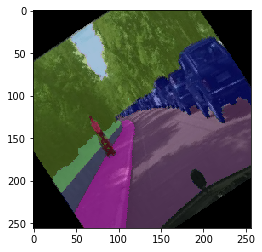

In [0]:
import tensorflow_addons as tfa

for x,y in dataset_train.take(1):
  x,y=x,y
rot_image_2=tfa.image.rotate(x,angles=32)
rot_image_1=tfa.image.rotate(y,angles=32)
plt.imshow(rot_image_2[0])
plt.imshow(decode(rot_image_1[0]),alpha=0.5)
plt.show()

In [0]:
import tensorflow_addons as tfa
compute_loss = Bootstrapped_cross_entropy(Multiplier=64,batch_size=3)
compute_accuracy = tf.keras.metrics.MeanIoU(num_classes=20)
@tf.function
def train_one_step(model,optimizer, x, y):
  grads=0
  with tf.GradientTape() as tape:
     logits = model(x)
     compute_accuracy(tf.argmax(y,axis=-1),tf.argmax(logits,axis=-1))
     loss = compute_loss(y, logits)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss



def train(model,epoch,optimizer,train_ds,val_ds):
  step=0
  loss = 0.0
  accuracy=0.0
  rot_shift=tf.random.uniform(shape=[500],minval=0,maxval=360)
  for i in range(epoch):
   for x, y in train_ds.take(500):
    x=tfa.image.rotate(x,angles=rot_shift[step-(500*i)])
    y=tfa.image.rotate(y,angles=rot_shift[step-(500*i)])

    if step==47501:
      optimizer.learning_rate.assign(0.000001)
    loss= train_one_step(model,optimizer, x, y)
    if step%100==0:
      tf.print('Step', step, ': loss', loss,': accuracy',compute_accuracy.result())
    step+=1
    checkpoint.step.assign_add(1)
   tf.print('Epoch', i, ': loss', loss,': accuracy',compute_accuracy.result())
   checkpoint.epoch.assign_add(0)
   #checkpoint.save(file_prefix=checkpoint_prefix)
  

   
    
  return step, loss


step,loss = train(model,3,adam,dataset_train,dataset_val)


In [0]:
%tensorboard --logdir logs/func

(3, 256, 256, 20)


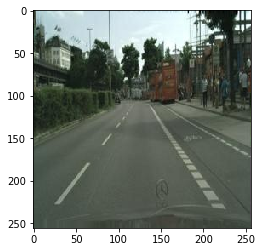

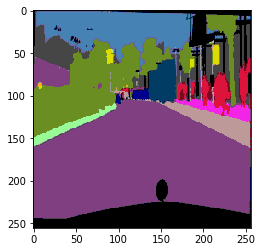

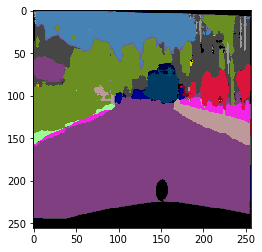

(3, 256, 256, 20)


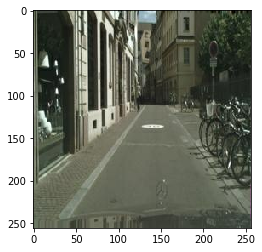

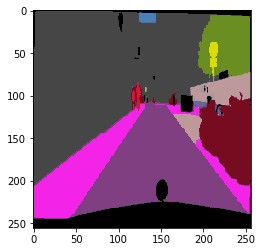

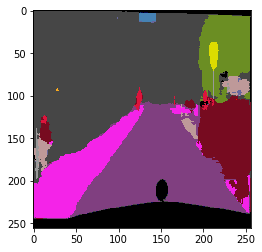

(3, 256, 256, 20)


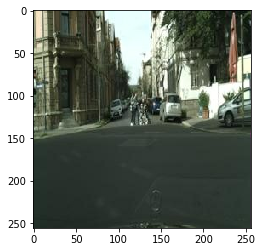

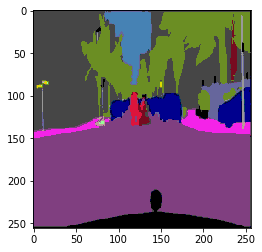

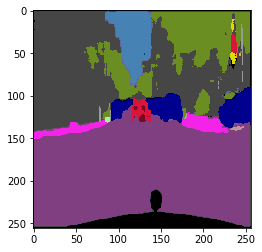

(3, 256, 256, 20)


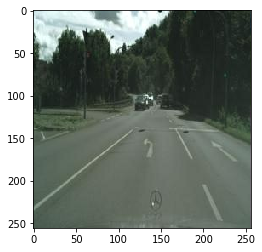

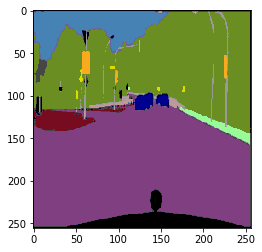

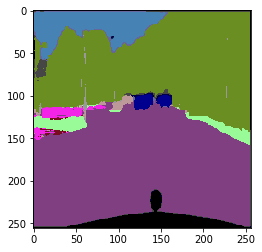

In [0]:
i=0

for img,target in dataset_val.take(4):
   x=model.predict(img)
   print(x.shape)
   pred_mask=decode(x[0])
   plt.imshow(img[0])
   plt.show()
   plt.imshow(decode(target[0]))
   plt.show()
   plt.imshow(pred_mask)
   plt.show()